In [2]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [2]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  weights = {
    SimilarityMetricEnum.compression_rate: 3,
    SimilarityMetricEnum.sum_differences: 2,
    SimilarityMetricEnum.arithmetic_average: 2,
    SimilarityMetricEnum.standard_derivative: 1,
    SimilarityMetricEnum.function_field: 1,
    SimilarityMetricEnum.diff_of_min: 1,
    SimilarityMetricEnum.diff_of_max: 1,
    SimilarityMetricEnum.min_max_diff: 1,
    # SimilarityMetricEnum.value_crossing: 1,
    # SimilarityMetricEnum.positive_value_crossing: 1,
    # SimilarityMetricEnum.negative_value_crossing: 1,
    # SimilarityMetricEnum.peak_count: 1,
    # SimilarityMetricEnum.positive_peak_count: 1,
    # SimilarityMetricEnum.negative_peak_count: 1,
    SimilarityMetricEnum.median: 2,
    SimilarityMetricEnum.covariance: 1,
    SimilarityMetricEnum.corelation_pearson: 1,
    SimilarityMetricEnum.corelation_spearman: 1,
  }
  ml_method_selector = MlMethodSelector()
  ml_method_selector.use_weights_strategy(weights)
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  classic_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "classic_time": [],
    "ml_compressed_size": [],
    "classic_compressed_size": [],
    "ml_compression_ratio": [],
    "classic_compression_ratio": [],
    "ml_method": [],
    "classic_method": [],
    "ml_score": [],
    "classic_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "classic_cbor_original_size": [],
    "classic_cbor_compressed_size": [],
    "classic_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "classic_json_original_size": [],
    "classic_json_compressed_size": [],
    "classic_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # measurements = measurement_provider.to_measurements(SignalGenerator(0, datasize).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2))
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_weights_strategy(measurements, compressed_data, weights)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = classic_method_selector.compress_with_best_weights_strategy(measurements, weights)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    classic_time = time_end - time_start
    classic_compressed_size = stats['compressed_size']
    classic_compression_ratio = stats['compression_rate'] * 100
    classic_method = stats['method_name']
    classic_score = metrics_score
    classic_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    classic_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    classic_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    classic_json_original_size = serialized_data_stats['senML_json_size_original']
    classic_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    classic_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['classic_time'].append(classic_time);
    results['classic_compressed_size'].append(classic_compressed_size);
    results['classic_compression_ratio'].append(classic_compression_ratio);
    results['classic_method'].append(classic_method);
    results['classic_score'].append(classic_score);
    results['classic_cbor_original_size'].append(classic_cbor_original_size);
    results['classic_cbor_compressed_size'].append(classic_cbor_compressed_size);
    results['classic_cbor_compressratio'].append(classic_cbor_compressratio);
    results['classic_json_original_size'].append(classic_json_original_size);
    results['classic_json_compressed_size'].append(classic_json_compressed_size);
    results['classic_json_compressratio'].append(classic_json_compressratio);

    print(f'{datasize},{ml_time},{classic_time},{ml_compressed_size},{classic_compressed_size},{ml_compression_ratio},{classic_compression_ratio},{ml_method},{classic_method},{ml_score},{classic_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{classic_cbor_original_size},{classic_cbor_compressed_size},{classic_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{classic_json_original_size},{classic_json_compressed_size},{classic_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [3]:
dataset = MeasurementProvider().get_random3()
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(0.3, 0.2)))

(0.4666666666666667, 0.7333333333333333)
datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
100,0.99462890625,88.060791015625,21,21,0.79,0.79,CompressNTHS_0.2,CompressNTHS_0.2,90.3552,90.3552,2291,713,0.6887821911828895,2291,713,0.6887821911828895,5354,1371,0.7439297721329847,5354,1371,0.7439297721329847
200,1.4580078125,247.8779296875,21,40,0.895,0.8,CompressNTHS_0.1,CompressPIP_PD_0.2,89.2311,90.9201,4291,713,0.8338382661384293,4291,1093,0.7452808203216034,10495,1382,0.8683182467841829,10495,2348,0.7762744163887566
300,2.100830078125,479.19189453125,31,60,0.896666666666666

In [3]:
# df = pd.read_csv('./results2a.csv')
# df['ml_compression_ratio'] *= 100
# df['classic_compression_ratio'] *= 100

In [4]:
df

,datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
0,100,0.994629,88.060791,21,21,79.000000,79.000000,CompressNTHS_0.2,CompressNTHS_0.2,90.3552,90.3552,2291,713,0.688782,2291,713,0.688782,5354,1371,0.743930,5354,1371,0.743930
1,200,1.458008,247.877930,21,40,89.500000,80.000000,CompressNTHS_0.1,CompressPIP_PD_0.2,89.2311,90.9201,4291,713,0.833838,4291,1093,0.745281,10495,1382,0.868318,10495,2348,0.776274
2,300,2.100830,479.191895,31,60,89.666667,80.000000,CompressNTHS_0.1,CompressPIP_ED_0.2,89.1035,90.8028,6292,913,0.854895,6292,1493,0.762715,15598,1908,0.877677,15580,3369,0.783761
3,400,2.872070,785.049072,41,81,89.750000,79.750000,CompressNTHS_0.1,CompressNTHS_0.2,89.6776,90.8318,8292,1113,0.865774,8292,1913,0.769296,20675,2406,0.883628,20675,4442,0.785151
4,500,3.267090,1147.903076,51,100,89.800000,80.000000,CompressNTHS_0.1,CompressPIP_ED_0.2,89.4357,90.8549,10292,1313,0.872425,10292,2293,0.777206,25847,2918,0.887105,25845,5420,0.790288
5,600,3.845215,1638.792969,61,121,89.833333,79.833333,CompressNTHS_0.1,CompressNTHS_0.2,89.3636,90.7760,12292,1513,0.876912,12292,2713,0.779287,31039,3447,0.888946,31040,6522,0.789884
6,700,4.486084,2108.583740,71,141,89.857143,79.857143,CompressNTHS_0.1,CompressNTHS_0.2,89.8024,90.8994,14380,1723,0.880181,14380,3131,0.782267,36215,3964,0.890543,36211,7551,0.791472
7,800,5.207031,2648.802979,81,161,89.875000,79.875000,CompressNTHS_0.1,CompressNTHS_0.2,89.3700,90.7910,16580,1943,0.882811,16580,3571,0.784620,41389,4482,0.891710,41376,8578,0.792682
8,900,5.780273,3483.963623,91,181,89.888889,79.888889,CompressNTHS_0.1,CompressNTHS_0.2,89.5650,90.8483,18780,2163,0.884824,18780,4011,0.786422,46549,4998,0.892629,46548,9622,0.793289
9,1000,6.322754,4153.118164,101,201,89.900000,79.900000,CompressNTHS_0.1,CompressNTHS_0.2,89.7828,90.9113,20980,2383,0.886416,20980,4451,0.787846,51675,5499,0.893585,51687,10647,0.794010


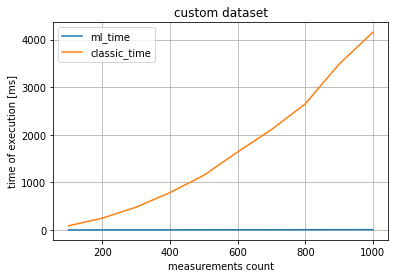

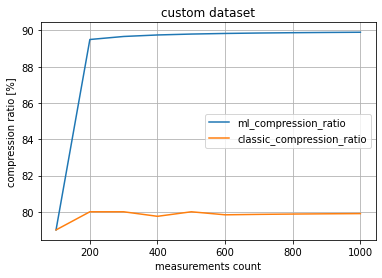

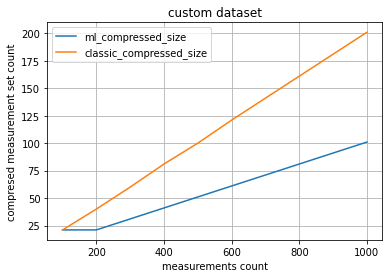

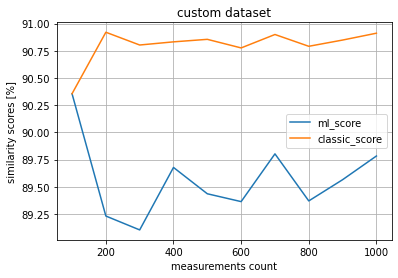

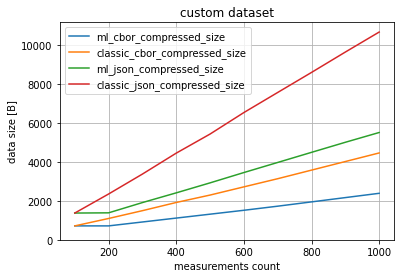

In [5]:
path = '../plot/strategy2'
ax = df.plot(x='datasize', y=['ml_time', 'classic_time'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'classic_compression_ratio'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

ax = df.plot(x='datasize', y=['ml_compressed_size', 'classic_compressed_size'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compresed measurement set count")
ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'classic_score'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4a.png')

ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'classic_cbor_compressed_size', 'ml_json_compressed_size', 'classic_json_compressed_size'], grid=True, ylim=0)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("data size [B]")
ax.figure.savefig(f'{path}/5a.png')


In [6]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(0.5, 0.5)
datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
100,1.246337890625,90.09814453125,10,10,0.9,0.9,CompressPIP_PD_0.1,CompressPIP_PD_0.1,89.9657,89.9657,2521,541,0.7854026180087267,2521,541,0.7854026180087267,5743,913,0.841023855127982,5743,913,0.841023855127982
200,1.5400390625,291.059326171875,21,20,0.895,0.9,CompressNTHS_0.1,CompressPIP_PD_0.1,86.3494,89.0551,4721,783,0.8341453081974158,4721,761,0.83880533785215,11185,1531,0.8631202503352704,11148,1434,0.871367061356297
300,3.570068359375,451.968017578125,30,60,0.9,0.8,CompressPIP_PD_0.1,CompressPIP_PD_0.2,88.9

In [6]:
# df = pd.read_csv('./results2b.csv')
# df['ml_compression_ratio'] *= 100
# df['classic_compression_ratio'] *= 100

In [7]:
df

,datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
0,100,1.246338,90.098145,10,10,90.000000,90.0,CompressPIP_PD_0.1,CompressPIP_PD_0.1,89.9657,89.9657,2521,541,0.785403,2521,541,0.785403,5743,913,0.841024,5743,913,0.841024
1,200,1.540039,291.059326,21,20,89.500000,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,86.3494,89.0551,4721,783,0.834145,4721,761,0.838805,11185,1531,0.863120,11148,1434,0.871367
2,300,3.570068,451.968018,30,60,90.000000,80.0,CompressPIP_PD_0.1,CompressPIP_PD_0.2,88.9884,89.3932,6922,981,0.858278,6922,1641,0.762930,16543,1947,0.882307,16544,3569,0.784272
3,400,2.817871,736.591064,41,40,89.750000,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,90.4020,90.7575,9122,1223,0.865929,9122,1201,0.868340,22028,2609,0.881560,21998,2520,0.885444
4,500,3.691895,1018.425781,51,50,89.800000,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,90.0529,90.9841,11322,1443,0.872549,11322,1421,0.874492,27436,3128,0.885989,27398,3037,0.889152
5,600,3.986816,1399.867920,61,60,89.833333,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,89.6716,91.4056,13522,1663,0.877015,13522,1641,0.878642,32960,3726,0.886954,32900,3615,0.890122
6,700,4.633301,1814.229004,71,70,89.857143,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,90.5621,91.3648,15722,1883,0.880232,15722,1861,0.881631,38385,4268,0.888811,38323,4157,0.891527
7,800,5.184082,2227.303223,81,80,89.875000,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,88.9079,91.3785,17922,2103,0.882658,17922,2081,0.883886,43763,4781,0.890752,43700,4669,0.893158
8,900,5.923828,2892.398193,91,90,89.888889,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,89.0282,91.7440,20122,2323,0.884554,20122,2301,0.885648,49313,5361,0.891286,49224,5218,0.893995
9,1000,6.405762,3392.187012,101,200,89.900000,80.0,CompressNTHS_0.1,CompressPIP_PD_0.2,89.8503,91.0147,22322,2543,0.886077,22322,4721,0.788505,54850,5905,0.892343,54774,11219,0.795177


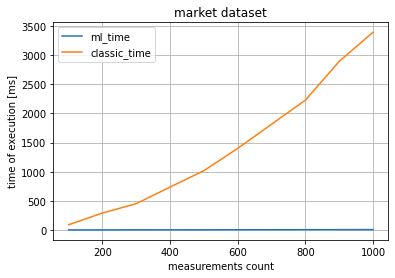

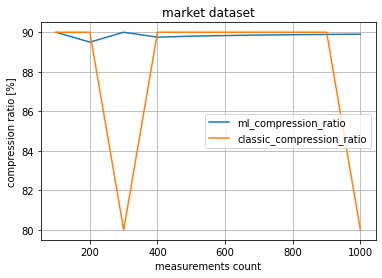

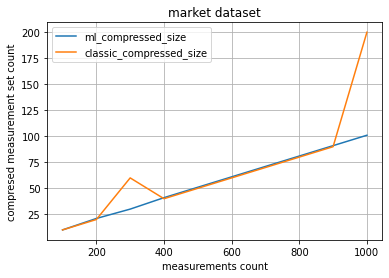

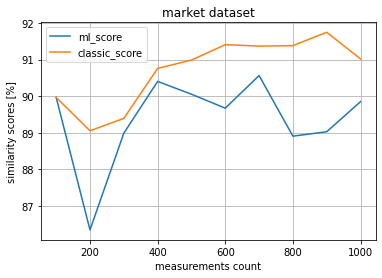

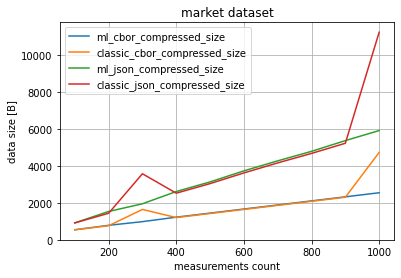

In [9]:
path = '../plot/strategy2'
ax = df.plot(x='datasize', y=['ml_time', 'classic_time'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'classic_compression_ratio'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

ax = df.plot(x='datasize', y=['ml_compressed_size', 'classic_compressed_size'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compresed measurement set count")
ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'classic_score'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4b.png')

ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'classic_cbor_compressed_size', 'ml_json_compressed_size', 'classic_json_compressed_size'], grid=True, ylim=0)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("data size [B]")
ax.figure.savefig(f'{path}/5b.png')
